# GraphRAG Knowledge Graph Exploration

This notebook helps you explore the knowledge graph built by GraphRAG v1.2.0.

**Knowledge Graph Stats (10 documents):**
- 176 entities
- 342 relationships
- 33 communities

**Prerequisites:**
- Run `poetry run python -m core.index` to build the knowledge graph
- Ensure output files exist in `output/` directory (create_final_*.parquet files)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

# Set up paths
output_dir = Path("..") / "output"

print(f"📂 Output directory: {output_dir}")
print(f"   Exists: {output_dir.exists()}")

📂 Output directory: ..\output
   Exists: True


## 1. Load Entities

In [2]:
# Load entities (GraphRAG v1.2.0 uses create_final_entities.parquet)
entities_df = pd.read_parquet(output_dir / "create_final_entities.parquet")

print(f"📊 Total Entities: {len(entities_df)}")
print(f"\n🏷️  Entity Types:")
print(entities_df['type'].value_counts())

entities_df.head()

📊 Total Entities: 176

🏷️  Entity Types:
type
ORGANIZATION    83
EVENT           36
PERSON          33
                16
GEO              8
Name: count, dtype: int64


,id,human_readable_id,title,type,description,text_unit_ids
0,e7dbb167-d427-4d1e-8a6c-0831fe6ca3e3,0,PROJECT ALPHA,EVENT,Project Alpha is TechVenture Inc.'s flagship i...,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
1,4c8d4f3f-77c9-4cff-9f8f-5e6c703be203,1,TECHVENTURE INC.,ORGANIZATION,TechVenture Inc. is a mid-sized technology com...,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
2,4d4aafa1-4659-456e-af6f-3fb042ebd2f4,2,DR. EMILY HARRISON,PERSON,Dr. Emily Harrison is a distinguished figure i...,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
3,303c0ff2-0f23-489b-ac9d-13372e057746,3,DAVID KUMAR,PERSON,David Kumar is a prominent figure at TechVentu...,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
4,1394db7b-dc42-4dd6-88cd-50a38766f1a7,4,AMANDA FOSTER,PERSON,Amanda Foster is a highly skilled professional...,[501eef3f811e3188d4001d67d7e7662531fee717bc738...


In [3]:
# Display entities in a table with their types and connection counts
entity_table = entities_df[['title', 'type']].copy()
entity_table.columns = ['Entity', 'Type']

# We'll add connections after building the graph (for now show without)
entity_table = entity_table.sort_values('Type').reset_index(drop=True)
entity_table.index = entity_table.index + 1  # Start index at 1

In [4]:
entity_table.head(20)

,Entity,Type
1,AI RESEARCH DEPARTMENT,
2,TRIVY,
3,MICROSOFT AZURE,
4,SECURITY SCAN,
5,STAGING ENVIRONMENT,
6,DEPLOYMENT,
7,ALPHA SQUAD,
8,INFRASTRUCTURE LEAD,
9,TECHSTARTUP LABS,
10,SAN FRANCISCO,


In [5]:
entity_table.tail(15)

,Entity,Type
162,RELEASE MANAGER,PERSON
163,EMILY HARRISON,PERSON
164,LISA WANG,PERSON
165,SARAH CHEN,PERSON
166,RACHEL ADAMS,PERSON
167,MICHAEL RODRIGUEZ,PERSON
168,JESSICA NGUYEN,PERSON
169,TOM BRADLEY,PERSON
170,JENNIFER PARK,PERSON
171,NINA KOWALSKI,PERSON


## 2. Load Relationships

In [6]:
# Load relationships (GraphRAG v1.2.0 uses create_final_relationships.parquet)
relationships_df = pd.read_parquet(output_dir / "create_final_relationships.parquet")

print(f"🔗 Total Relationships: {len(relationships_df)}")
print(f"\n📈 Relationship Types:")
if 'description' in relationships_df.columns:
    print(relationships_df['description'].value_counts().head(10))
else:
    print("No relationship types found")

relationships_df.head()

🔗 Total Relationships: 342

📈 Relationship Types:
description
Project Alpha is the flagship initiative of TechVenture Inc.                                                                                                                                                                                                                                                                                                                                                                                                    1
Sarah Chen and Robert Thompson are both involved in significant roles within their organization. Sarah Chen holds a senior position, as Robert Thompson reports to her in his capacity as the Vice President of Product. Their professional relationship is further highlighted by their joint attendance at a contract signing ceremony held at GlobalBank HQ, indicating their active participation in key corporate events and decision-making processes.    1
David Kumar leads the Product Engineer

,id,human_readable_id,source,target,description,weight,combined_degree,text_unit_ids
0,e0b7df28-a344-4787-9f87-3c8a292dc4e1,0,PROJECT ALPHA,TECHVENTURE INC.,Project Alpha is the flagship initiative of Te...,9.0,104,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
1,1005b244-de76-4090-9766-ce47864aa450,1,PROJECT ALPHA,DR. EMILY HARRISON,Dr. Emily Harrison is the Project Lead for Pro...,9.0,44,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
2,0a65c127-e52c-4034-a23b-7097ae3b2db1,2,PROJECT ALPHA,DAVID KUMAR,David Kumar is the Technical Architect for Pro...,8.0,48,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
3,3c6abca4-f41b-48c8-8a30-83ddd44f2635,3,PROJECT ALPHA,AMANDA FOSTER,Amanda Foster is the Product Owner for Project...,8.0,38,[501eef3f811e3188d4001d67d7e7662531fee717bc738...
4,6f7c5d9c-9a60-42b6-a540-87e10a3e0cb1,4,PROJECT ALPHA,DR. JAMES MITCHELL,Dr. James Mitchell works on LLM integration fo...,7.0,33,[501eef3f811e3188d4001d67d7e7662531fee717bc738...


## 3. Visualize Knowledge Graph

Create a network graph visualization of entities and relationships.

In [7]:
# Create a NetworkX graph
G = nx.Graph()

# Add nodes (entities) - use 'title' column in v1.2.0
for idx, row in entities_df.iterrows():
    G.add_node(row['title'], type=row['type'])

# Add edges (relationships) - limit to top relationships for visualization
top_relationships = relationships_df.head(50)  # Limit for readability
for idx, row in top_relationships.iterrows():
    if 'source' in row and 'target' in row:
        G.add_edge(row['source'], row['target'], relationship=row.get('description', 'related'))

print(f"📊 Graph Stats:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")
if G.number_of_nodes() > 1:
    print(f"   Density: {nx.density(G):.4f}")

📊 Graph Stats:
   Nodes: 176
   Edges: 37
   Density: 0.0024


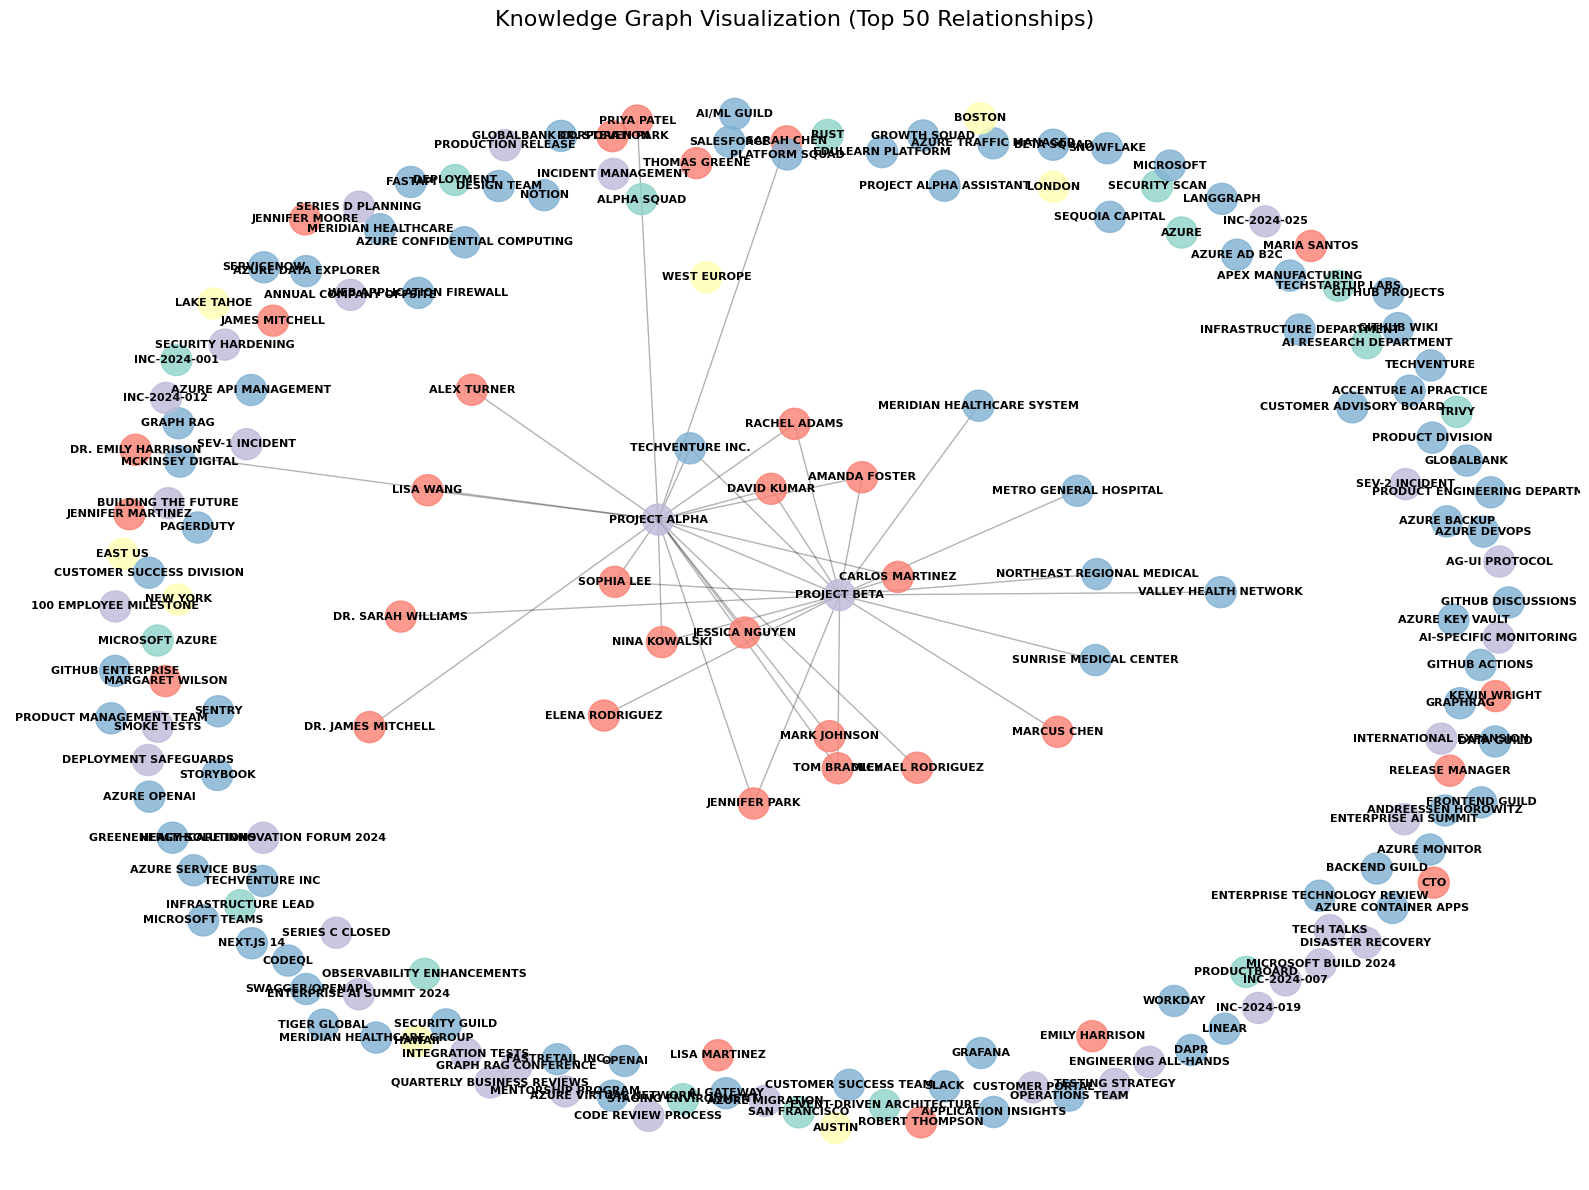


🎨 Legend:
   : 16 nodes
   GEO: 8 nodes
   EVENT: 36 nodes
   PERSON: 33 nodes
   ORGANIZATION: 83 nodes


In [8]:
# Visualize the graph
if G.number_of_nodes() == 0:
    print("⚠️  No nodes to visualize. Check if entities and relationships were loaded correctly.")
else:
    plt.figure(figsize=(16, 12))

    # Use spring layout for positioning
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Color nodes by entity type - use 'title' column in v1.2.0
    entity_types = entities_df.set_index('title')['type'].to_dict()
    node_colors = [entity_types.get(node, 'unknown') for node in G.nodes()]

    # Create color map
    unique_types = list(set(node_colors))
    color_map = plt.cm.Set3(range(len(unique_types)))
    type_to_color = {t: color_map[i] for i, t in enumerate(unique_types)}
    node_colors_rgb = [type_to_color[t] for t in node_colors]

    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors_rgb, node_size=500, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title("Knowledge Graph Visualization (Top 50 Relationships)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Legend
    print("\n🎨 Legend:")
    for entity_type in unique_types:
        count = sum(1 for t in node_colors if t == entity_type)
        print(f"   {entity_type}: {count} nodes")

## 4. Explore Communities

In [9]:
# Load community reports (GraphRAG v1.2.0 uses create_final_community_reports.parquet)
communities_df = pd.read_parquet(output_dir / "create_final_community_reports.parquet")

print(f"🏘️  Total Communities: {len(communities_df)}")
print(f"\n📋 Community Levels:")
if 'level' in communities_df.columns:
    print(communities_df['level'].value_counts())
else:
    print("No level information found")

communities_df.head()

🏘️  Total Communities: 33

📋 Community Levels:
level
1    25
0     8
Name: count, dtype: int64


,id,human_readable_id,community,parent,level,title,summary,full_content,rank,rank_explanation,findings,full_content_json,period,size
0,6f789b8ac45643e8846edb7920a6558c,8,8,0,1,Accenture AI Practice and Maria Santos,The community is centered around the Accenture...,# Accenture AI Practice and Maria Santos\n\nTh...,6.5,The impact severity rating is moderate due to ...,[{'explanation': 'Accenture AI Practice is a k...,"{\n ""title"": ""Accenture AI Practice and Mar...",2026-02-05,2
1,2e54345aecac4d0883764b79ec542a93,9,9,0,1,TechVenture Inc. and Its Strategic Ecosystem,TechVenture Inc. is a mid-sized technology com...,# TechVenture Inc. and Its Strategic Ecosystem...,8.5,The impact severity rating is high due to Tech...,[{'explanation': 'TechVenture Inc. is a leader...,"{\n ""title"": ""TechVenture Inc. and Its Stra...",2026-02-05,36
2,af29b6923cdd49949b95479cd55f4636,10,10,0,1,Kevin Wright and TechVenture Inc. Operations,"The community is centered around Kevin Wright,...",# Kevin Wright and TechVenture Inc. Operations...,6.5,The impact severity rating is moderate to high...,[{'explanation': 'Kevin Wright is a crucial pr...,"{\n ""title"": ""Kevin Wright and TechVenture ...",2026-02-05,2
3,ce3d16cc8ed94adf9fb81a34e5204abc,11,11,0,1,TechVenture Inc. Documentation Tools,The community is centered around TechVenture I...,# TechVenture Inc. Documentation Tools\n\nThe ...,4.5,The impact severity rating is moderate due to ...,[{'explanation': 'Notion is a key entity withi...,"{\n ""title"": ""TechVenture Inc. Documentatio...",2026-02-05,3
4,7ded3db71d86452eaddacede682a6fd6,12,12,0,1,London and TechVenture Inc.'s International Ex...,The community is centered around TechVenture I...,# London and TechVenture Inc.'s International ...,6.5,The impact severity rating is moderate to high...,[{'explanation': 'London has been chosen as th...,"{\n ""title"": ""London and TechVenture Inc.'s...",2026-02-05,2


In [10]:
# Show sample community summaries
print("📖 Sample Community Summaries:\n")

for idx, row in communities_df.head(3).iterrows():
    community_id = row.get('community', row.get('id', 'Unknown'))
    level = row.get('level', 'N/A')
    print(f"Community {community_id} (Level {level}):")
    print(f"Title: {row.get('title', 'N/A')}")
    summary = row.get('summary', row.get('full_content', 'N/A'))
    if isinstance(summary, str) and len(summary) > 200:
        print(f"Summary: {summary[:200]}...")
    else:
        print(f"Summary: {summary}")
    print("\n" + "="*60 + "\n")

📖 Sample Community Summaries:

Community 8 (Level 1):
Title: Accenture AI Practice and Maria Santos
Summary: The community is centered around the Accenture AI Practice, which provides implementation services for TechVenture's enterprise customers. Maria Santos, as the Managing Director, plays a pivotal role ...


Community 9 (Level 1):
Title: TechVenture Inc. and Its Strategic Ecosystem
Summary: TechVenture Inc. is a mid-sized technology company specializing in AI-powered enterprise solutions, with a robust network of partnerships and customers. The company leverages Microsoft Azure for its c...


Community 10 (Level 1):
Title: Kevin Wright and TechVenture Inc. Operations
Summary: The community is centered around Kevin Wright, a key professional at TechVenture Inc., who leads the Operations Team. His role encompasses quality assurance, operations management, and technical overs...




## 5. Entity Analysis

Find the most connected entities (highest degree centrality).

In [11]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Sort by centrality
top_entities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("⭐ Top 10 Most Connected Entities:\n")
for entity, centrality in top_entities:
    entity_type = entity_types.get(entity, 'unknown')
    print(f"   {entity} ({entity_type}): {centrality:.3f}")

⭐ Top 10 Most Connected Entities:

   PROJECT ALPHA (EVENT): 0.109
   PROJECT BETA (EVENT): 0.109
   TECHVENTURE INC. (ORGANIZATION): 0.011
   DAVID KUMAR (PERSON): 0.011
   AMANDA FOSTER (PERSON): 0.011
   SOPHIA LEE (PERSON): 0.011
   NINA KOWALSKI (PERSON): 0.011
   JENNIFER PARK (PERSON): 0.011
   TOM BRADLEY (PERSON): 0.011
   JESSICA NGUYEN (PERSON): 0.011


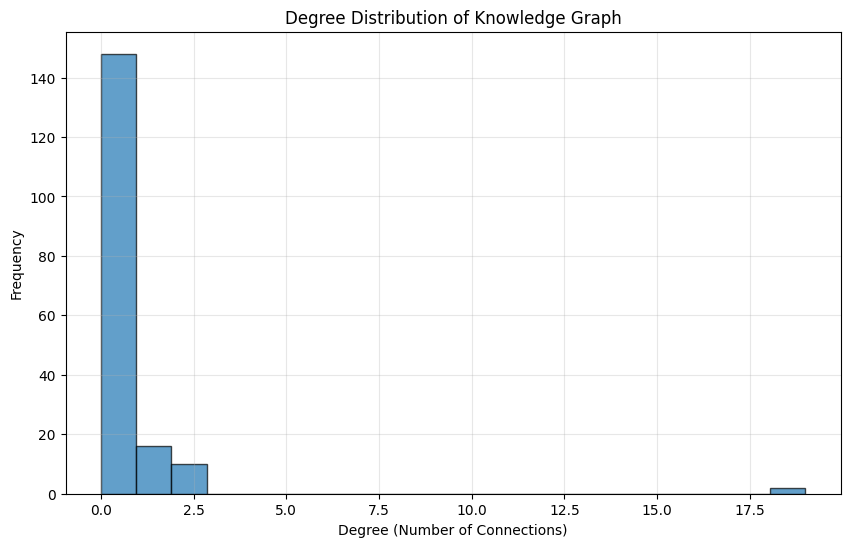


📊 Degree Statistics:
   Mean: 0.42
   Max: 19
   Min: 0


In [12]:
# Visualize degree distribution
degrees = [G.degree(n) for n in G.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Degree (Number of Connections)')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Knowledge Graph')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📊 Degree Statistics:")
print(f"   Mean: {sum(degrees)/len(degrees):.2f}")
print(f"   Max: {max(degrees)}")
print(f"   Min: {min(degrees)}")

## 6. Search Examples

Test some search queries (requires running search scripts).

In [13]:
print("💡 Search Queries using Python API:\n")
print("# In terminal:")
print("# Local Search (specific questions):")
print('poetry run python -m core.example "Who leads Project Alpha?"')
print('poetry run python -m core.example "What technologies are used in Project Alpha?"')
print('poetry run python -m core.example "Who resolved the GraphRAG index corruption incident?"')
print("\n# Global Search (thematic questions):")
print('poetry run python -m core.example "What are the main projects?" --type global')
print('poetry run python -m core.example "Summarize the organizational structure" --type global')
print("\n# Or use Python API directly:")
print("""
import asyncio
from core import load_all, local_search, global_search

data = load_all()

# Local search
response, context = asyncio.run(local_search("Who leads Project Alpha?", data))
print(response)

# Global search  
response, context = asyncio.run(global_search("What are the main projects?", data))
print(response)
""")

💡 Search Queries using Python API:

# In terminal:
# Local Search (specific questions):
poetry run python -m core.example "Who leads Project Alpha?"
poetry run python -m core.example "What technologies are used in Project Alpha?"
poetry run python -m core.example "Who resolved the GraphRAG index corruption incident?"

# Global Search (thematic questions):
poetry run python -m core.example "What are the main projects?" --type global
poetry run python -m core.example "Summarize the organizational structure" --type global

# Or use Python API directly:

import asyncio
from core import load_all, local_search, global_search

data = load_all()

# Local search
response, context = asyncio.run(local_search("Who leads Project Alpha?", data))
print(response)

# Global search  
response, context = asyncio.run(global_search("What are the main projects?", data))
print(response)



## Next Steps

1. **Run More Queries:** Try cross-document queries like "Who resolved the GraphRAG index corruption incident?"
2. **Explore Different Entity Types:** Filter the graph by specific entity types
3. **Analyze Specific Communities:** Deep dive into community structures
4. **Add More Documents:** Expand the knowledge graph with additional content

**Python API Reference:**
```python
from core import load_all, local_search, global_search, drift_search, basic_search
```

For Part 2, we'll explore:
- FastMCP server integration
- RESTful API for GraphRAG queries
- Production deployment patterns